In [1]:
import numpy as np
import time, os
import pandas as pd

trainset_dir = "./dataset/log_TH_KAL_train"
testset_dir = "./dataset/log_TH_KAL_test"
actions = os.listdir(trainset_dir)

seq_length = 32                                  #윈도우 사이즈
created_time = int(time.time())                 #행동 녹화 시간

os.makedirs('created_dataset', exist_ok=True)

In [2]:
data = []
label = []

for idx, action in enumerate(actions):

    action_dir = trainset_dir + '/' + actions[idx]

    for i in os.listdir(action_dir):
        dataset = pd.read_csv(f"{action_dir}/{i}") 
        np_dataset = dataset.to_numpy()[:,0:2]
        data_len = np_dataset.shape[0]


        num_data = data_len // seq_length
        spare = data_len % seq_length
        np_dataset = np_dataset[:(data_len-spare)]


        for j in range(num_data):
            sequence = np_dataset[j::num_data]
            # print(sequence.shape)
            data.append(sequence)
            label.append(action)
        # print(data_len, num_data, spare)

action_list = set(label)
            
print(len(data))
print(len(label))

4273
4273


In [3]:
# data.reshape((4273*32, 2))

In [4]:
# from sklearn.preprocessing import StandardScaler

# # scaler = StandardScaler()

# scaler.fit(data)
# data = scaler.transform(data)
# data.shape

In [5]:
dictionary = {string : i for i,string in enumerate(action_list)}

In [6]:
new_label = []
for l in label:
    new_label.append(dictionary[l])


In [7]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [8]:
new_label = to_categorical(new_label,12)
new_label
data = np.array(data)

In [9]:
new_label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [10]:
model = Sequential([
    LSTM(64, activation='tanh',return_sequences=True, input_shape=(32, 2)),
    LSTM(128, activation='tanh',return_sequences=True,),
    LSTM(64, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(12, activation='softmax')    
])

In [11]:
from sklearn.model_selection import train_test_split

data, data_val, new_label, new_label_val = train_test_split(data, new_label, test_size=0.1, random_state=24)

In [13]:
data.shape

(3845, 32, 2)

In [15]:
data[0,0]

array([2.34280462, 0.99336296])

In [14]:
new_label.shape

(3845, 12)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(
    data,
    new_label,
    validation_data=(data_val, new_label_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 64)            17152     
                                                                 
 lstm_1 (LSTM)               (None, 32, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 12)                204       
                                                                 
Total params: 168,188
Trainable params: 168,188
Non-trai

KeyboardInterrupt: 

In [ ]:
print(data)

[[[2.34280462 0.99336296]
  [2.35148942 1.00487332]
  [2.36223517 1.02461043]
  ...
  [2.61753424 1.12413722]
  [2.61175946 1.14521744]
  [2.61329806 1.1692245 ]]

 [[1.67814345 1.67316467]
  [1.67806493 1.67458738]
  [1.6746825  1.664584  ]
  ...
  [1.80432268 1.91792174]
  [1.78869817 1.90243546]
  [1.77670239 1.87523454]]

 [[1.66848439 1.71859634]
  [1.66915956 1.72766848]
  [1.66460696 1.72441458]
  ...
  [1.66077726 1.87981634]
  [1.64231411 1.85948218]
  [1.63838526 1.83612479]]

 ...

 [[1.55473392 1.74088812]
  [1.58594899 1.74298683]
  [1.61960014 1.75409338]
  ...
  [1.61215124 1.86210927]
  [1.61070393 1.82202032]
  [1.60707588 1.78907229]]

 [[2.05266997 2.05920685]
  [2.04598881 2.03160882]
  [2.03967937 2.00840933]
  ...
  [1.70166318 1.81814801]
  [1.69831697 1.79759335]
  [1.69601478 1.7735345 ]]

 [[0.87502418 1.86370998]
  [0.87837326 1.86075243]
  [0.89552518 1.83919395]
  ...
  [0.68217199 1.16164305]
  [0.59284167 1.17002612]
  [0.50406139 1.20630728]]]


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("./models/model.h5")

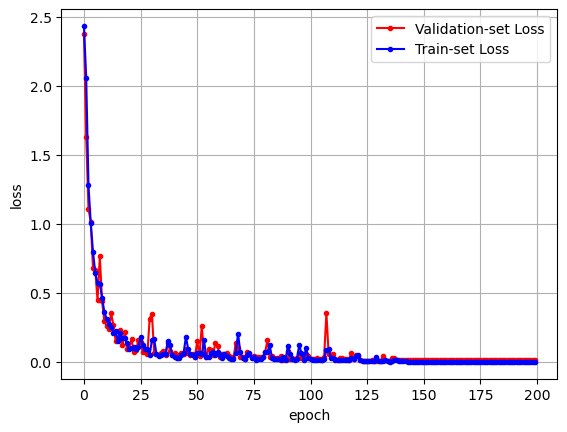

In [ ]:
from matplotlib import pyplot as plt

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
data_test = []
label_test = []

for idx, action in enumerate(actions):

    action_dir = testset_dir + '/' + actions[idx]

    for i in os.listdir(action_dir):
        dataset_test = pd.read_csv(f"{action_dir}/{i}")
        np_dataset_test = dataset_test.to_numpy()[:,0:2]
        data_len_test = np_dataset_test.shape[0]


        num_data_test = data_len_test // seq_length
        spare_test = data_len_test % seq_length
        np_dataset_test = np_dataset_test[:(data_len_test-spare_test)]


        for j in range(num_data_test):
            sequence_test = np_dataset_test[j::num_data_test]
            # print(sequence.shape)
            data_test.append(sequence_test)
            label_test.append(action)
        # print(data_len, num_data, spare)

action_list = set(label)
data_test = np.array(data_test)

In [ ]:
new_label_test = []
for l in label_test:
    new_label_test.append(dictionary[l])

new_label_test = np.array(new_label_test)
new_label_test

array([8, 8, 8, ..., 6, 6, 6])

In [ ]:
print(data_test.shape)

(1532, 32, 2)


In [ ]:
from sklearn.metrics import classification_report

predict = model.predict(data_test)
predict = np.argmax(predict, axis=1)
predict.shape

(1532,)

In [ ]:

# np.set_printoptions(threshold=np.inf, linewidth=np.inf) 

In [ ]:
predict

array([8, 8, 8, ..., 6, 6, 6], dtype=int64)

In [ ]:
classification_report(new_label_test, predict, target_names=action_list)

'              precision    recall  f1-score   support\n\n          ld       0.83      0.88      0.85       100\n          rd       0.69      0.85      0.77       109\n          ms       0.92      0.88      0.90       186\n          lu       0.89      0.89      0.89        95\n          os       0.97      0.95      0.96       211\n         squ       0.93      0.75      0.83       199\n         ver       0.85      0.88      0.86        40\n          mc       0.91      0.80      0.85       122\n         hor       0.65      0.72      0.69        47\n         tri       0.77      0.91      0.83       165\n          ru       0.93      0.89      0.91       112\n          oc       0.91      0.91      0.91       146\n\n    accuracy                           0.87      1532\n   macro avg       0.85      0.86      0.85      1532\nweighted avg       0.88      0.87      0.87      1532\n'